In [1]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteOEQJ65/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteOEQJ65/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [2]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [3]:
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples
train_data_len, test_data_len

(3680, 3669)

In [6]:
import tensorflow as tf

def load_image(datapoint):
    img = tf.image.resize(datapoint['image'], (128, 128))
    mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    img = tf.cast(img, tf.float32)
    img = img / 255
    mask -= 1

    return img, mask

In [7]:
train_dataset = dataset['train'].map(load_image)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

test_dataset = dataset['test'].map(load_image)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(1)

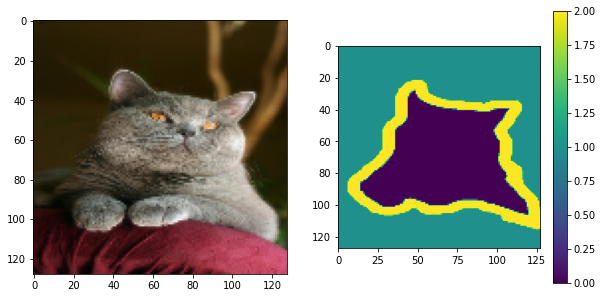

In [9]:
import matplotlib.pyplot as plt
import numpy as np

for img, mask in train_dataset.take(1):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img[2])

    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(mask[2], axis=2))
    plt.colorbar()

In [10]:
def REDNet_segmentation(num_layers):
    conv_layers = []
    deconv_layers = []
    residual_layers = []

    inputs = tf.keras.layers.Input(shape=(None, None, 3))
    conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))

    for i in range(num_layers-1):
        conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
        deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))
    
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='softmax'))

    x = conv_layers[0](inputs)

    for i in range(num_layers-1):
        x = conv_layers[i+1](x)
        if i % 2 == 0:
            residual_layers.append(x)

    for i in range(num_layers-1):
        if i % 2 == 1:
            x = tf.keras.layers.Add()([x, residual_layers.pop()])
            x = tf.keras.layers.Activation('relu')(x)
        x = deconv_layers[i](x)
    
    x = deconv_layers[-1](x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [11]:
model = REDNet_segmentation(15)
model.compile(optimizer=tf.optimizers.Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(train_dataset, epochs=20, steps_per_epoch=train_data_len//16, validation_data=test_dataset, validation_steps=test_data_len)

Epoch 1/20
230/230 [==============================] - 158s 648ms/step - loss: 0.9352 - accuracy: 0.5422 - val_loss: 0.8362 - val_accuracy: 0.5980
Epoch 2/20
230/230 [==============================] - 148s 646ms/step - loss: 0.7855 - accuracy: 0.6108 - val_loss: 0.7107 - val_accuracy: 0.6842
Epoch 3/20
230/230 [==============================] - 149s 648ms/step - loss: 0.6814 - accuracy: 0.7027 - val_loss: 0.6679 - val_accuracy: 0.7195
Epoch 4/20
230/230 [==============================] - 149s 648ms/step - loss: 0.6232 - accuracy: 0.7338 - val_loss: 0.6544 - val_accuracy: 0.7151
Epoch 5/20
230/230 [==============================] - 149s 649ms/step - loss: 0.5897 - accuracy: 0.7502 - val_loss: 0.5806 - val_accuracy: 0.7515
Epoch 6/20
230/230 [==============================] - 149s 649ms/step - loss: 0.5627 - accuracy: 0.7633 - val_loss: 0.5501 - val_accuracy: 0.7673
Epoch 7/20
230/230 [==============================] - 150s 652ms/step - loss: 0.5437 - accuracy: 0.7723 - val_loss: 0.5317 -

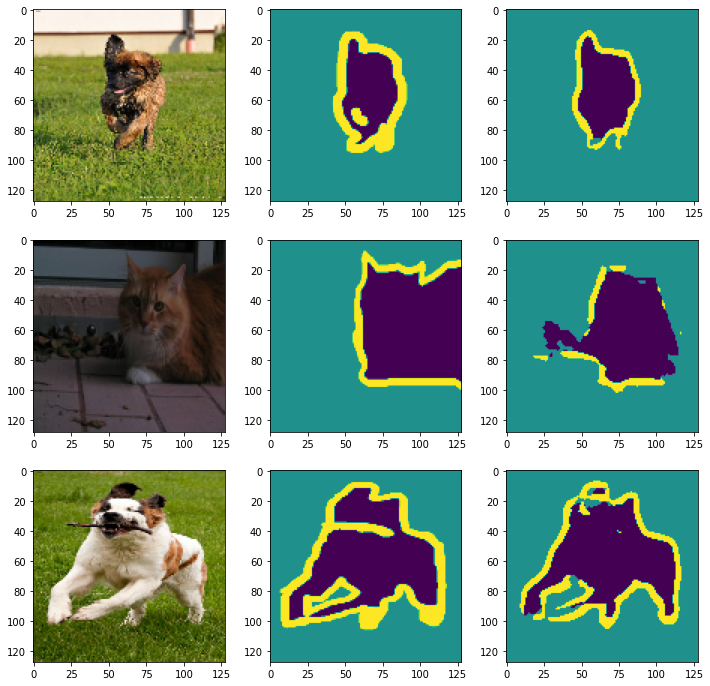

In [13]:
plt.figure(figsize=(12, 12))
for idx, (img, mask) in enumerate(test_dataset.take(3)):
    plt.subplot(3, 3, idx*3+1)
    plt.imshow(img[0])

    plt.subplot(3, 3, idx*3+2)
    plt.imshow(np.squeeze(mask[0], axis=2))

    predict = tf.argmax(model.predict(img), axis=-1)
    plt.subplot(3, 3, idx*3+3)
    plt.imshow(predict[0])